In [1]:
import torch.optim as optim
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, StepLR
import time
from datetime import timedelta
from tqdm import tqdm
import os

In [2]:
from QNRF_Dataloader import prepare_dataloaders
train_dir = "./Datasets/UCF-QNRF_ECCV18/Train"
test_dir = "./Datasets/UCF-QNRF_ECCV18/Test"
train_loader, val_loader, test_loader = prepare_dataloaders(train_dir=train_dir, test_dir=test_dir, val_split=0.2)

In [3]:
from swin_wnet_model import SwinWnet
from utilities import MAE_BCE_Loss, visualize_density_maps, plot_losses, calculate_density_map_metrics

In [4]:
torch.cuda.device_count()

1

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler=None):
    start_time = time.time()
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_mae = 0.0
        running_mse = 0.0
        running_rmse = 0.0
        batch = 0
        num_batches = len(train_loader)
        for images, target_density_maps, target_reinforcement_maps in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training Progress: "):
            images, target_density_maps, target_reinforcement_maps = images.cuda(), target_density_maps.cuda(), target_reinforcement_maps.cuda()
            
            optimizer.zero_grad()
            generated_density_maps, generated_reinforcement_maps = model(images)
        
            loss = criterion(generated_density_maps, generated_reinforcement_maps, target_density_maps, target_reinforcement_maps)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            mae, mse, rmse = calculate_density_map_metrics(generated_density_maps, target_density_maps)
            running_mae += mae
            running_mse += mse
            running_rmse += rmse

        avg_train_loss = running_loss / len(train_loader)
        avg_train_mae = running_mae / len(train_loader)
        avg_train_mse = running_mse / len(train_loader)
        avg_train_rmse = running_rmse / len(train_loader)
        
        train_losses.append(avg_train_loss)          

        model.eval()
        val_running_loss = 0.0
        val_running_mae = 0.0
        val_running_mse = 0.0
        val_running_rmse = 0.0
        batch = 0
        num_batches = len(val_loader)
        with torch.no_grad():
            for images, target_density_maps, target_reinforcement_maps in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Validation Progress: "):
                images, target_density_maps, target_reinforcement_maps = images.cuda(), target_density_maps.cuda(), target_reinforcement_maps.cuda()
                
                generated_density_maps, generated_reinforcement_maps = model(images)
        
                loss = criterion(generated_density_maps, generated_reinforcement_maps, target_density_maps, target_reinforcement_maps)
    
                val_running_loss += loss.item()
                mae, mse, rmse = calculate_density_map_metrics(generated_density_maps, target_density_maps)
                val_running_mae += mae
                val_running_mse += mse
                val_running_rmse += rmse

        avg_val_loss = val_running_loss / len(val_loader)
        avg_val_mae = val_running_mae / len(val_loader)
        avg_val_mse = val_running_mse / len(val_loader)
        avg_val_rmse = val_running_rmse / len(val_loader)
        
        val_losses.append(avg_val_loss)  
            
        if (epoch + 1) % 20 == 0 or (epoch + 1) == num_epochs:
            print(f"Epoch [{epoch+1}/{num_epochs}] Training - Loss: {avg_train_loss:.5f}, MAE: {avg_train_mae:.5f}, MSE: {avg_train_mse:.5f}, RMSE: {avg_train_rmse:.5f}")
            print(f"Epoch [{epoch+1}/{num_epochs}] Validation - Loss: {avg_val_loss:.5f}, MAE: {avg_val_mae:.5f}, MSE: {avg_val_mse:.5f}, RMSE: {avg_val_rmse:.5f}")
        
        if scheduler is not None:
            scheduler.step()
        
        
    end_time = time.time()
    time_diff = end_time - start_time
    time_taken = timedelta(seconds=time_diff)
    print(f"Time took to complete training: {time_taken}")
    
    return train_losses, val_losses

In [7]:
def initialize_model_weights(model):
    for module in model.modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            nn.init.kaiming_normal_(module.weight)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)

In [8]:
model = SwinWnet()
initialize_model_weights(model)
if torch.cuda.is_available() and torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
model = model.cuda()

criterion = MAE_BCE_Loss()

optimizer = optim.Adam(model.parameters(), lr=1e-3)

scheduler = StepLR(optimizer, step_size=20, gamma=0.1)

In [9]:
num_epochs = 200
train_losses, val_losses = train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler=None)

Epoch 20/200 - Validation Progress: 100%|██████████| 15/15 [00:35<00:00,  2.37s/it]


Epoch [20/200] Training - Loss: 19.04936, MAE: 0.01449, MSE: 0.00168, RMSE: 0.03788
Epoch [20/200] Validation - Loss: 17.73335, MAE: 0.01265, MSE: 0.00172, RMSE: 0.03931


Epoch 40/200 - Validation Progress: 100%|██████████| 15/15 [00:34<00:00,  2.32s/it]


Epoch [40/200] Training - Loss: 14.34123, MAE: 0.01122, MSE: 0.00124, RMSE: 0.03240
Epoch [40/200] Validation - Loss: 16.46167, MAE: 0.01298, MSE: 0.00187, RMSE: 0.04161


Epoch 60/200 - Validation Progress: 100%|██████████| 15/15 [00:35<00:00,  2.33s/it]


Epoch [60/200] Training - Loss: 16.39206, MAE: 0.01287, MSE: 0.00156, RMSE: 0.03637
Epoch [60/200] Validation - Loss: 25.34618, MAE: 0.02131, MSE: 0.00181, RMSE: 0.04136


Epoch 80/200 - Validation Progress: 100%|██████████| 15/15 [00:34<00:00,  2.32s/it]


Epoch [80/200] Training - Loss: 13.72499, MAE: 0.01083, MSE: 0.00113, RMSE: 0.03068
Epoch [80/200] Validation - Loss: 17.38691, MAE: 0.01339, MSE: 0.00155, RMSE: 0.03703


Epoch 100/200 - Validation Progress: 100%|██████████| 15/15 [00:34<00:00,  2.33s/it]


Epoch [100/200] Training - Loss: 11.49521, MAE: 0.00913, MSE: 0.00075, RMSE: 0.02587
Epoch [100/200] Validation - Loss: 14.02506, MAE: 0.01101, MSE: 0.00145, RMSE: 0.03700


Epoch 120/200 - Validation Progress: 100%|██████████| 15/15 [00:34<00:00,  2.30s/it]


Epoch [120/200] Training - Loss: 11.91428, MAE: 0.00927, MSE: 0.00083, RMSE: 0.02662
Epoch [120/200] Validation - Loss: 14.26570, MAE: 0.01120, MSE: 0.00117, RMSE: 0.03279


Epoch 140/200 - Validation Progress: 100%|██████████| 15/15 [00:34<00:00,  2.30s/it]


Epoch [140/200] Training - Loss: 10.19410, MAE: 0.00796, MSE: 0.00057, RMSE: 0.02264
Epoch [140/200] Validation - Loss: 13.07983, MAE: 0.01002, MSE: 0.00121, RMSE: 0.03347


Epoch 160/200 - Validation Progress: 100%|██████████| 15/15 [00:34<00:00,  2.31s/it]


Epoch [160/200] Training - Loss: 9.50541, MAE: 0.00762, MSE: 0.00048, RMSE: 0.02074
Epoch [160/200] Validation - Loss: 12.82292, MAE: 0.00983, MSE: 0.00121, RMSE: 0.03245


Epoch 180/200 - Validation Progress: 100%|██████████| 15/15 [00:34<00:00,  2.30s/it]


Epoch [180/200] Training - Loss: 8.19666, MAE: 0.00658, MSE: 0.00035, RMSE: 0.01753
Epoch [180/200] Validation - Loss: 12.72899, MAE: 0.00978, MSE: 0.00120, RMSE: 0.03327


Epoch 200/200 - Validation Progress: 100%|██████████| 15/15 [00:34<00:00,  2.31s/it]

Epoch [200/200] Training - Loss: 8.29586, MAE: 0.00683, MSE: 0.00036, RMSE: 0.01780
Epoch [200/200] Validation - Loss: 12.62288, MAE: 0.00946, MSE: 0.00110, RMSE: 0.03134
Time took to complete training: 11:06:16.739187


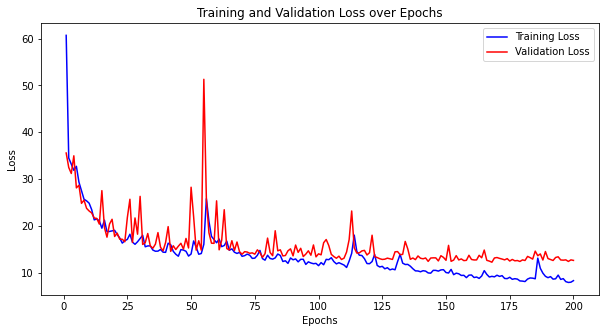

In [10]:
plot_losses(train_losses, val_losses)

In [11]:
torch.save(model.state_dict(), 'model.pth')